<h1 align="center"> IST 5520 Milestone 2: Data Analysis I <h1>
<h3 align="center"> AirBnB Dataset <h3>

#### Student: Ronald Adomako
#### Student: Idris Dobbs
#### Student: Narendra Chigili
#### Student: Nikhil Srirama Sai

# Cleanse and visualize data

## Introduction

AirBnB is a PaaS for the short term rental market. Users use the platform to list residences for short term rentals. We noticed that for big cities, such as New York City, there are many host and some may want to use AirBnB for lucrative means. Given location and characteristics of a property, a new host would want to know whether he or she is charging the optimal amount to rent the space to lodgers.

We noticed that from the New York City dataset for AirBnB, the categorical variable for location  was too coarse. The descriptor says the location is categorized into five boroughs. For a big city such as New York City, there are a lot of insights missing from a business perspective because neighborhoods vary drastically in property amenities even within a single borough. Moreso, the geo-coordinates are too fine for business purposes. To handle this we implement a zip code converter to categorize properties based on their location - Feature Selection.

- What are the largest determinants / predictors of AirBnB rental prices?
- How can we optimize rental revenue based on rental location and other characteristics?
- What price should be charged based on rental location/ characteristics?

We are opperating under the assumption that NYC AirBnB prices has reached a *steady-state*: i.e. the market has been active for long enough in NYC and there are enough data points (observations) in NYC that the **mean** is meaningful.

We want to know whether a host is charging an optimal price. To do this we group the observations by neigborhood and then take the average price. Hosts who charge at or above this price are considered optimal in their respective neighborhood while hosts who charge below the average price for their neighborhood are sub-optimal. Consider the case where all hosts charge the same price within a neighborhood, then the mean is the mode is the median- uniform data, no variance. All the hosts in this neighborhood would be optimal.

Consider the case where one of those hosts charge below what would have been the average, then only that host is sub-optimal while the rest are optimal. Conversely, if one host charge above the rest while everyone else charges the same, then that one host would be optimal while the rest are suboptimal.

Along with the *steady-state* assumption, by grouping the data by neighborhoods we assume that on average homes and amenities are similar by neighborhood. The geo-coordinates are too fine a scale and the boroughs are too coarse a scale. A meso-scale would be by zipcode, which we would expect to have higher precision of similarities between host, or by neighborhood. For a dataset with 39881 observations, transforming geo-coordinates prove to be computationally expensive (22 hours on standard household computer). We chose the next best meso-scale: what AirBnB features as "neighbourhood".

From a business perspective, we want to know what percent of hosts per neighborhood are charging an optimal price, and aggregating this data the percent hosts charge an optimal price in NYC overall. We see that using the neighborhood grouping allows us to compare on a common scale for all hosts. We don't have hosts income, so we wouldn't be able to measure profit. Likewise, revenue wouldn't be a fair scale because hosts with more units will outperform host with smaller units just by volume. A nieghborhood comparison allows a better metric to assess price per room, where we expect reasonably small variance per neighborhood. Furthermore, comparing by percentage is normalizes our comparison in general.

## Data Source and Collection

#### We chose the AirBnB dataset for New York City (NYC). We want to build a model that indicates whether hosts are charging an optimum amount for their rental.

http://insideairbnb.com/new-york-city/

[data dictionary](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit?usp=sharing)

http://insideairbnb.com/get-the-data

http://data.insideairbnb.com/united-states/ny/new-york-city/2022-09-07/visualisations/listings.csv



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sidetable as stb
import numpy as np
# import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
import seaborn as sb
from scipy import stats as st
import statsmodels as sts
import statsmodels.api as sm

%matplotlib inline

In [2]:
data = pd.read_csv('Grp3Project_InitialData/data_dictionary.csv')
csv_URL = "http://data.insideairbnb.com/united-states/ny/new-york-city/2022-09-07/visualisations/listings.csv"
df2 = pd.read_csv(csv_URL)

In [3]:
data_dict = pd.DataFrame(df2.columns, columns=['Features'])
data_dict['Description']=None

### Dimensional Analysis
- What are the largest determinants / predictors of AirBnB rental prices?

The data dictionary for New York City AirBnB dataset consists of 75 columns (variables or features) and 39881 observations. Based on our research question and several [Kaggle challenges](https://www.kaggle.com/search?q=airbnb-listing-in-nyc) (www.kaggle.com/search?q=airbnb-listing-in-nyc) we reduced our dimensions to the following **18** features for preliminary analysis.

In [4]:
for i,feature in enumerate(df2.columns):
    #print(feature)
    #print(type(feature))
    val = data[data['Field']==feature]['Description'].values
    try:
        data_dict.loc[i,'Description'] = val[0]
    except: #IndexError
        data_dict.loc[i,'Description'] = None
        
    if feature == 'neighbourhood':
        data_dict.loc[i,'Description'] = \
            'Neighborhood equivalent for zip code group'
    if feature == 'neighbourhood_group':
        data_dict.loc[i,'Description'] = \
            'Borough'        
        
pd.set_option('display.max_colwidth', 100)
data_dict


,Features,Description
0,id,Airbnb's unique identifier for the listing
1,name,Name of the listing
2,host_id,Airbnb's unique identifier for the host/user
3,host_name,Name of the host. Usually just the first name(s).
4,neighbourhood_group,Borough
5,neighbourhood,Neighborhood equivalent for zip code group
6,latitude,Uses the World Geodetic System (WGS84) projection for latitude and longitude.
7,longitude,Uses the World Geodetic System (WGS84) projection for latitude and longitude.
8,room_type,[Entire home/apt|Private room|Shared room|Hotel]
9,price,daily price in local currency


In [5]:
csv_URL = "http://data.insideairbnb.com/united-states/ny/new-york-city/2022-09-07/visualisations/listings.csv"
df = pd.read_csv(csv_URL)

## Data Manipulation

In [6]:
df['neighbourhood_group'].unique()

array(['Brooklyn', 'Queens', 'Bronx', 'Manhattan', 'Staten Island'],
      dtype=object)

In [7]:
#Create a data frame grouping by neighborhood for average price
hood_price_obj = df[['neighbourhood','price']].groupby('neighbourhood')
df_mean_price = hood_price_obj.mean()
df_mean_price[['price']] = df_mean_price[['price']].round(2)
df_mean_price

,price
neighbourhood,
Allerton,118.78
Arden Heights,113.86
Arrochar,132.06
Arverne,230.26
Astoria,109.01
...,...
Windsor Terrace,175.40
Woodhaven,94.53
Woodlawn,141.00


In [8]:
df_mean_price.info()

<class 'pandas.core.frame.DataFrame'>
Index: 244 entries, Allerton to Woodside
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   244 non-null    float64
dtypes: float64(1)
memory usage: 3.8+ KB


**We have reduced 39881 into 244 rows of manageable data!**

In [9]:
df.stb.freq(['neighbourhood'])

,neighbourhood,count,percent,cumulative_count,cumulative_percent
0,Bedford-Stuyvesant,2779,6.968230,2779,6.968230
1,Williamsburg,2456,6.158321,5235,13.126551
2,Harlem,1878,4.709009,7113,17.835561
3,Midtown,1701,4.265189,8814,22.100750
4,Bushwick,1657,4.154861,10471,26.255610
...,...,...,...,...,...
239,Fort Wadsworth,1,0.002507,39877,99.989970
240,Ferry Point Park,1,0.002507,39878,99.992478
241,Country Club,1,0.002507,39879,99.994985
242,Bull's Head,1,0.002507,39880,99.997493


In [10]:
#df = df2.sort_values('neighbourhood')
df_hood = df.stb.freq(['neighbourhood'])
df_hood = df_hood.loc[:,'neighbourhood':'percent']
df_hood = df_hood.sort_values('neighbourhood')

In [11]:
df_hood.reset_index(inplace=True)

In [12]:
df_mean = df_mean_price[['price']].reset_index()
df_mean.head()

,neighbourhood,price
0,Allerton,118.78
1,Arden Heights,113.86
2,Arrochar,132.06
3,Arverne,230.26
4,Astoria,109.01


In [13]:
df_hood['price'] = df_mean['price']
df_hood.rename(columns={'index':'pop_rank'}, inplace=True)
df_hood.head()

,pop_rank,neighbourhood,count,percent,price
0,107,Allerton,45,0.112836,118.78
1,204,Arden Heights,7,0.017552,113.86
2,158,Arrochar,17,0.042627,132.06
3,64,Arverne,110,0.275821,230.26
4,14,Astoria,686,1.720117,109.01


## Data Summarization and Visualization
- How can we optimize rental revenue based on rental location and other characteristics?

*We choose the mode, because the mode remains the same after making corrections for outliers*


### Inspect distribution of top three most populous neighborhoods

In [14]:
df_hood.sort_values(by='pop_rank').head()

,pop_rank,neighbourhood,count,percent,price
12,0,Bedford-Stuyvesant,2779,6.968230,140.85
237,1,Williamsburg,2456,6.158321,183.21
108,2,Harlem,1878,4.709009,164.74
144,3,Midtown,1701,4.265189,381.70
30,4,Bushwick,1657,4.154861,114.35


In [15]:
df2_s1 = df.groupby('neighbourhood').get_group('Bedford-Stuyvesant')
df2_s2 = df.groupby('neighbourhood').get_group('Williamsburg')
df2_s3 = df.groupby('neighbourhood').get_group('Harlem')

In [16]:
df_top3= pd.concat([df2_s1,df2_s2,df2_s3])

#### Bedford-Stuyvesant

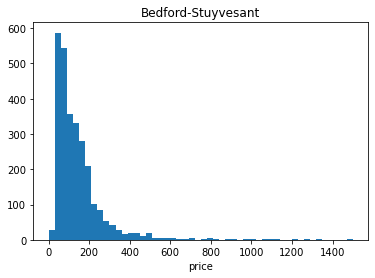

In [17]:
plt.hist(df2_s1.price, bins=50)
plt.title('Bedford-Stuyvesant')
plt.xlabel('price');

#### Examine extremes of prices - Bed Stuy

In [18]:
top_out = np.log(df2_s1.price).max()
bot_out = np.log(df2_s1.price).min()
print(f'Log of outlier for uncorrected prices: {bot_out,top_out}');

Log of outlier for uncorrected prices: (-inf, 7.313220387090301)


/opt/anaconda3/envs/MyEnv/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [19]:
#prices greater than a dollar ($1)
df2_s1_corrected = df2_s1[df2_s1['price']>1]

top_out = np.log(df2_s1_corrected.price).max()
bot_out = np.log(df2_s1_corrected.price).min()
print(f'Log of outlier for corrected prices: {bot_out,top_out}');

Log of outlier for corrected prices: (2.70805020110221, 7.313220387090301)


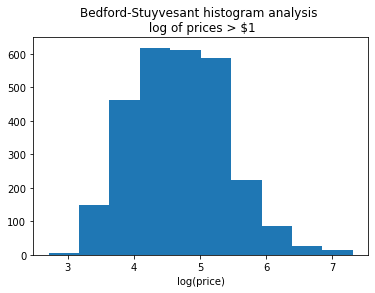

In [20]:
plt.hist(np.log(df2_s1_corrected.price))
plt.title('Bedford-Stuyvesant histogram analysis \n log of prices > \$1')
plt.xlabel('log(price)');

In [21]:
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

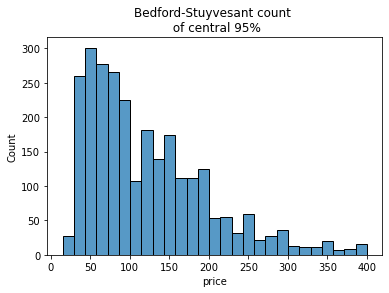

In [22]:
sb.histplot(reject_outliers(df2_s1[ df2_s1['price']>0 ]['price']))
plt.title('Bedford-Stuyvesant count \n of central 95%')
plt.show()

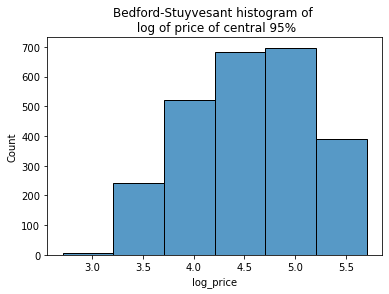

In [23]:
array = reject_outliers(reject_outliers(df2_s1[ df2_s1['price']>0 ]['price']))
array.name = 'log_price'

sb.histplot(np.log(array), binwidth=0.5)
plt.title('Bedford-Stuyvesant histogram of \n log of price of central 95%')
plt.show()

In [24]:
bed_stuy_mean = np.mean(array)
bed_stuy_median = np.median(array)
bed_stuy_mode = st.mode(array)

print('Bedford Stuyversant\n')
print(f'mean: ${int(bed_stuy_mean)}')
print(f'median: ${int(bed_stuy_median)}')
print(f'mode: ${bed_stuy_mode.mode[0]}')
print(f'count: {len(array)}')

Bedford Stuyversant

mean: $111
median: $98
mode: $150
count: 2540


In [25]:
log_array = np.log(array)
bed_stuy_mean = np.mean(log_array)
bed_stuy_median = np.median(log_array)
bed_stuy_mode = st.mode(log_array)

print('Bedford Stuyversant\n')
print(f'mean of log of prices: {round(bed_stuy_mean,2)}')
print(f'median of log of prices: {round(bed_stuy_median,2)} ≠ log(median)')
print(f'mode of log of prices: {round(bed_stuy_mode.mode[0],2)}')
print(f'count: {len(array)}')

Bedford Stuyversant

mean of log of prices: 4.55
median of log of prices: 4.58 ≠ log(median)
mode of log of prices: 5.01
count: 2540


### Bed-stuy "Entire Home/ Apt"

In [26]:
df2_bedstuy = df.groupby('neighbourhood').get_group('Bedford-Stuyvesant')
df2_bedstuy;

In [27]:
df2_bedstuy_apt = df2_bedstuy.groupby('room_type').get_group('Entire home/apt')
df2_bedstuy_apt;

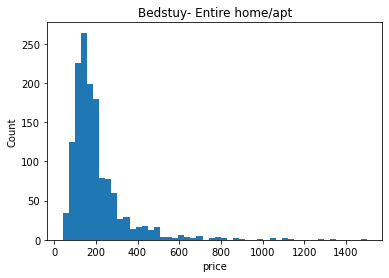

In [28]:
plt.hist(df2_bedstuy_apt.price, bins=50)
plt.title('Bedstuy- Entire home/apt')
plt.xlabel('price')
plt.ylabel("Count");

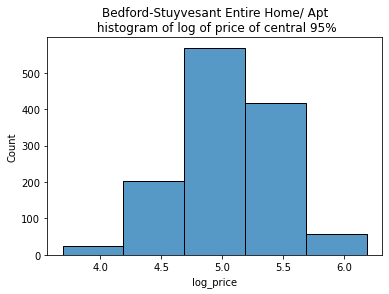

In [29]:
bedstuy_array = reject_outliers(df2_bedstuy_apt[ df2_bedstuy_apt['price']>0 ]['price'])
array = reject_outliers(bedstuy_array)
array.name = 'log_price'

sb.histplot(np.log(array), binwidth=0.5)
plt.title('Bedford-Stuyvesant Entire Home/ Apt'+\
    '\n histogram of log of price of central 95%')
plt.show()

In [30]:
log_array = np.log(array)
bed_stuy_mean = np.mean(log_array)
bed_stuy_median = np.median(log_array)
bed_stuy_mode = st.mode(log_array)

print('Bedford Stuyversant Entire Home/ Apt')
print(f'mean of log of prices: {round(bed_stuy_mean,2)}')
print(f'median of log of prices: {round(bed_stuy_median,2)} ≠ log(median)')
print(f'mode of log of prices: {round(bed_stuy_mode.mode[0],2)}')
print(f'count: {len(array)}\n')

print(f'log(median): {round(np.log(np.median(array)),2)}')

Bedford Stuyversant Entire Home/ Apt
mean of log of prices: 5.04
median of log of prices: 5.04 ≠ log(median)
mode of log of prices: 5.01
count: 1273

log(median): 5.04


#### Williamsburg

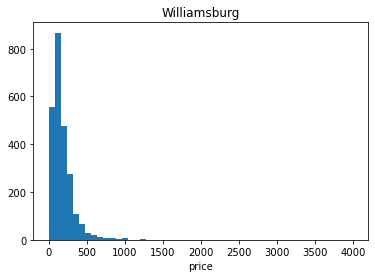

In [31]:
plt.hist(df2_s2.price, bins=50)
plt.title('Williamsburg')
plt.xlabel("price");

#### Examine extreme of prices - Williamsburg

/opt/anaconda3/envs/MyEnv/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Log of outlier for uncorrected prices: (-inf, 8.293049139768444)
Log of outlier for corrected prices: (3.0, 8.29)


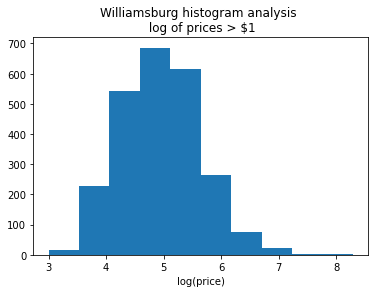

In [32]:
top_out = np.log(df2_s2.price).max()
bot_out = np.log(df2_s2.price).min()
print(f'Log of outlier for uncorrected prices: {bot_out,top_out}')

#prices greater than a dollar ($1)
df2_s2_corrected = df2_s2[df2_s2['price']>1]
top_out = np.log(df2_s2_corrected.price).max()
bot_out = np.log(df2_s2_corrected.price).min()
print(f'Log of outlier for corrected prices: {round(bot_out,2),round(top_out,2)}')

plt.hist(np.log(df2_s2_corrected.price))
plt.title('Williamsburg histogram analysis \n log of prices > \$1')
plt.xlabel('log(price)');

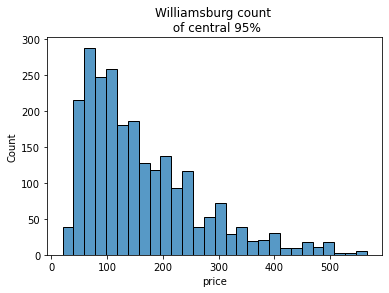

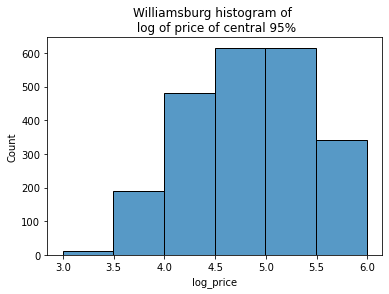

In [33]:
sb.histplot(reject_outliers(df2_s2[ df2_s2['price']>0 ]['price']))
plt.title('Williamsburg count \n of central 95%')
plt.show()

array = reject_outliers(reject_outliers(df2_s2[ df2_s2['price']>0 ]['price']))
array.name = 'log_price'

sb.histplot(np.log(array), binwidth=0.5)
plt.title('Williamsburg histogram of \n log of price of central 95%')
plt.show()

In [34]:
williamsburg_mean = np.mean(array)
williamsburg_median = np.median(array)
williamsburg_mode = st.mode(array)

print('Williamsburg\n')
print(f'mean: ${int(williamsburg_mean)}')
print(f'median: ${int(williamsburg_median)}')
print(f'mode: ${williamsburg_mode.mode[0]}')
#print(f'count: {len(array)}')

log_array = np.log(array)
williamsburg_mean = np.mean(log_array)
williamsburg_median = np.median(log_array)
williamsburg_mode = st.mode(log_array)
print('\n')
print(f'mean of natural log of prices: {round(williamsburg_mean,2)}')
print(f'median of natural log of prices: {round(williamsburg_median,2)} ≠ ln(median)')
print(f'mode of natural log of prices: {round(williamsburg_mode.mode[0],2)}')
print(f'count: {len(array)}')

Williamsburg

mean: $144
median: $125
mode: $200


mean of natural log of prices: 4.81
median of natural log of prices: 4.83 ≠ ln(median)
mode of natural log of prices: 5.3
count: 2253


### Williamsburg "Entire Home/ Apt"

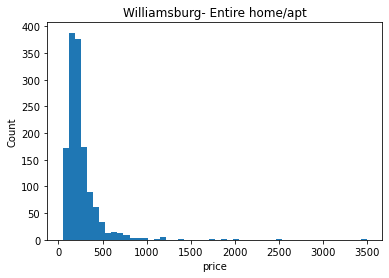

In [35]:
df2_williamsburg = df.groupby('neighbourhood').get_group('Williamsburg')
df2_williamsburg_apt = df2_williamsburg.groupby('room_type').get_group('Entire home/apt')
plt.hist(df2_williamsburg_apt.price, bins=50)
plt.title('Williamsburg- Entire home/apt')
plt.xlabel('price')
plt.ylabel("Count");

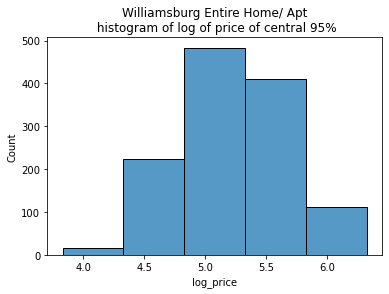

In [36]:
williamsburg_array = reject_outliers(df2_williamsburg_apt[ df2_williamsburg_apt['price']>0 ]['price'])
array = reject_outliers(williamsburg_array)
array.name = 'log_price'

sb.histplot(np.log(array), binwidth=0.5)
plt.title('Williamsburg Entire Home/ Apt'+\
    '\n histogram of log of price of central 95%')
plt.show()

In [37]:
log_array = np.log(array)
williamsburg_mean = np.mean(log_array)
williamsburg_median = np.median(log_array)
williamsburg_mode = st.mode(log_array)

print('Williamsburg Entire Home/ Apt\n')
print(f'mean of log of prices: {round(williamsburg_mean,2)}')
print(f'median of log of prices: {round(williamsburg_median,2)} ≠ log(median)')
print(f'mode of log of prices: {round(williamsburg_mode.mode[0],2)}')
print(f'count: {len(array)}')

Williamsburg Entire Home/ Apt

mean of log of prices: 5.25
median of log of prices: 5.28 ≠ log(median)
mode of log of prices: 5.3
count: 1244


#### Harlem

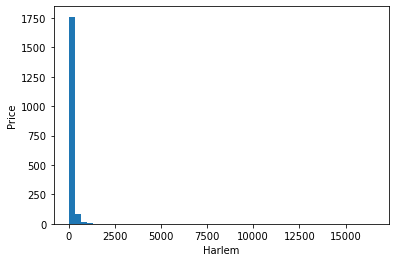

In [38]:
plt.hist(df2_s3.price,bins = 50)
plt.xlabel('Harlem')
plt.ylabel("Price");

#### Examine extreme of prices - Harlem

Log of outlier for uncorrected prices: (2.3, 9.71)
Log of outlier for corrected prices: (2.3, 9.71)


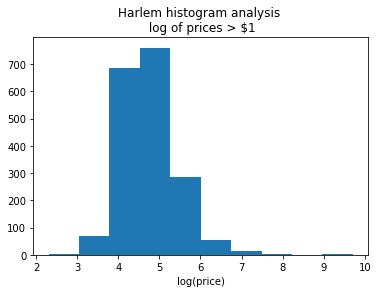

In [39]:
top_out = np.log(df2_s3.price).max()
bot_out = np.log(df2_s3.price).min()
print(f'Log of outlier for uncorrected prices: {round(bot_out,2),round(top_out,2)}')

#prices greater than a dollar ($1)
df2_s3_corrected = df2_s3[df2_s3['price']>1]
top_out = np.log(df2_s3_corrected.price).max()
bot_out = np.log(df2_s3_corrected.price).min()
print(f'Log of outlier for corrected prices: {round(bot_out,2),round(top_out,2)}')

plt.hist(np.log(df2_s3_corrected.price))
plt.title('Harlem histogram analysis \n log of prices > \$1')
plt.xlabel('log(price)');

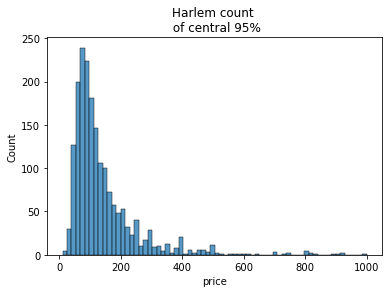

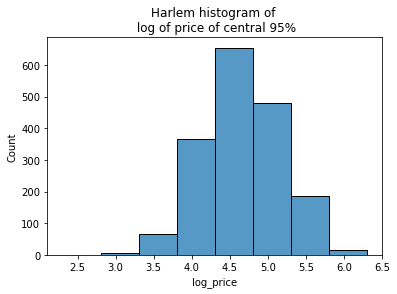

In [40]:
sb.histplot(reject_outliers(df2_s3[ df2_s3['price']>0 ]['price']))
plt.title('Harlem count \n of central 95%')
plt.show()

array = reject_outliers(reject_outliers(df2_s3[ df2_s3['price']>0 ]['price']))
array.name = 'log_price'

sb.histplot(np.log(array), binwidth=0.5)
plt.title('Harlem histogram of \n log of price of central 95%')
plt.show()

In [41]:
harlem_mean = np.mean(array)
harlem_median = np.median(array)
harlem_mode = st.mode(array)

print('Harlem\n')
print(f'mean: ${int(harlem_mean)}')
print(f'median: ${int(harlem_median)}')
print(f'mode: ${harlem_mode.mode[0]}')
#print(f'count: {len(array)}')

log_array = np.log(array)
harlem_mean = np.mean(log_array)
harlem_median = np.median(log_array)
harlem_mode = st.mode(log_array)
print('\n')
print(f'mean of natural log of prices: {round(harlem_mean,2)}')
print(f'median of natural log of prices: {round(harlem_median,2)} ≠ ln(median)')
print(f'mode of natural log of prices: {round(harlem_mode.mode[0],2)}')
print(f'count: {len(array)}')

Harlem

mean: $121
median: $100
mode: $100


mean of natural log of prices: 4.66
median of natural log of prices: 4.61 ≠ ln(median)
mode of natural log of prices: 4.61
count: 1774


### Harlem "Entire Home/ Apt"

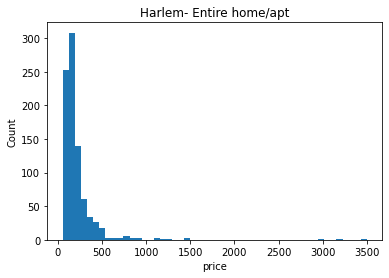

In [42]:
df2_harlem = df.groupby('neighbourhood').get_group('Harlem')
df2_harlem_apt = df2_harlem.groupby('room_type').get_group('Entire home/apt')
plt.hist(df2_harlem_apt.price, bins=50)
plt.title('Harlem- Entire home/apt')
plt.xlabel('price')
plt.ylabel("Count");

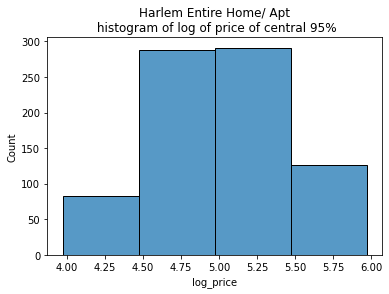

In [43]:
harlem_array = reject_outliers(df2_harlem_apt[ df2_harlem_apt['price']>0 ]['price'])
array = reject_outliers(harlem_array)
array.name = 'log_price'

sb.histplot(np.log(array), binwidth=0.5)
plt.title('Harlem Entire Home/ Apt'+\
    '\n histogram of log of price of central 95%')
plt.show()

In [44]:
log_array = np.log(array)
harlem_mean = np.mean(log_array)
harlem_median = np.median(log_array)
harlem_mode = st.mode(log_array)

print('Harlem Entire Home/ Apt\n')
print(f'mean of log of prices: {round(harlem_mean,2)}')
print(f'median of log of prices: {round(harlem_median,2)} ≠ log(median)')
print(f'mode of log of prices: {round(harlem_mode.mode[0],2)}')
print(f'count: {len(array)}')

Harlem Entire Home/ Apt

mean of log of prices: 5.01
median of log of prices: 5.01 ≠ log(median)
mode of log of prices: 5.01
count: 789


#### Interpretation

The aim was to get a normally distributed curve for our assumptions in obtaining a mean price per night. Without correcting for outliers, the data seems to approach a logarithmic or skewed normally distributed curve, in which case taking the median or mode for the optimum price would be most appropriate. We choose the mode, since this measure is more stable as it directly depends on the y-axis of the histogram where as the mean and median directly depends on the x-axis.

### Proportion of AirBNB Listings by Borough and Room Type in NYC

The 1st pie chart shows 95% of the AirBnB listings are in Manhattan, Brooklyn and Queens. Brooklyn and Staten Island make up the remaining listings. Manhattan and Brooklyn alone make up neary 80% of the listings.

The 2nd pie chart shows the listings distributed by room type. Most of the observations consist of entire home / apartments, or private rooms. Hotel and shared rooms are an insignificant proportion of the distribution.

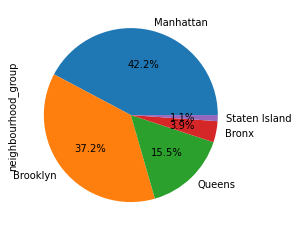

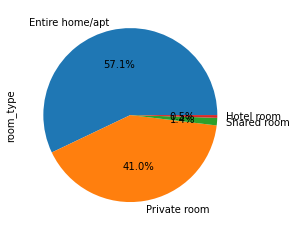

In [45]:
#Create a pie chart showing the percentage of listings per bourrough.
df1 = df.neighbourhood_group.value_counts()
df1.plot.pie(autopct="%.1f%%")
plt.show()

df2 = df.room_type.value_counts()
df2.plot.pie(autopct="%.1f%%")
plt.show()

### NYC AirBNB Listing Price Statistics by Borough

The table and box/whisker plots above provide illustration of the frequency, price statistics, and price distribution by neighborhood group or burrough in New York City. There is wide variability in the observations, with standard deviations consistently higher than the mean for each burrough. Mean prices are consistently higher than the median price, which suggest the prevalance of high values or outliers in the dataset that are pulling up the average. Average prices are highest in Manhattan, Brooklyn, and Queens respectively.

neighbourhood_group       price                         \
                                  count        mean median         std min   
neighbourhood_group                                                          
Bronx                              1568  124.737245   90.0  278.572839   0   
Brooklyn                          14845  157.927114  115.0  209.526092   0   
Manhattan                         16847  264.933341  175.0  473.171623   0   
Queens                             6175  131.365506   94.0  213.120396   0   
Staten Island                       446  143.163677  103.5  194.997315  33   

                            
                       max  
neighbourhood_group         
Bronx                 9994  
Brooklyn             10000  
Manhattan            16500  
Queens               10000  
Staten Island         2500

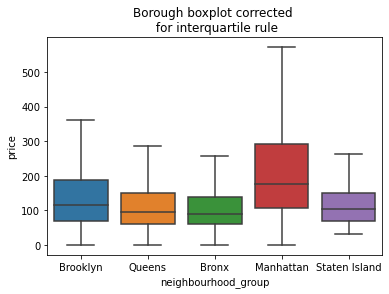

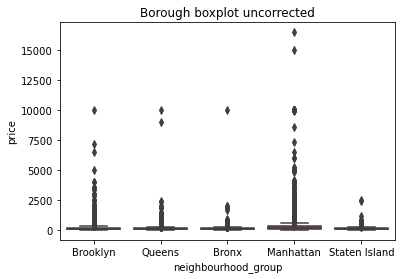

In [46]:
#Display the table of price statistics and counts by New York City burrough.
display(df.groupby('neighbourhood_group').aggregate({'neighbourhood_group':'count',
                                    'price':['mean','median','std','min','max']}))

#Plot boxplot with outliers turned off.
sb.boxplot(y = df['price'], 
            x = df['neighbourhood_group'], 
            showfliers = False)
plt.title('Borough boxplot corrected \n for interquartile rule')
plt.show()

sb.boxplot(y = df['price'], x = df['neighbourhood_group'], showfliers = True)
plt.title('Borough boxplot uncorrected')
plt.show()

### NYC AirBNB Listing Price Statistics by Room Type
The table and box/whisker plots above provide illustration of the frequency, price statistics, and price distribution by room type in New York City. As in the distribution by borough section, there is wide variuability with standard deviations consistently higher than the mean for each burrough (Hotel rooms being the exception). Mean prices are also consistently higher than the median price, which suggest the prevalance of high values or outliers in the dataset that are pulling up the average. Comparisons of the 1st boxplot (corrected for outliers) with the second (not corrected for outliers bear this out.

#### Major Room Type Categories
These categories encompass 98% of the listings and are likely to be more useful for informing business decisions.
- Entire home/apt: Entire residences make up 57% of the dataset and are the category with the second highest average price. Prices range from \\$10 to \\$15K which could be indicative of data errors and/ or outliers.
- Private room: Private rooms constitute 42% of the listings in the data and are the category with the third highest average price. Prices range from \\$10 to \\$16.5K which could be indicative of data errors and/ or outliers.

#### Minor Room Type Categories
Categories that are a significantly smaller number of the overall listings in the dataset. They are less likely to be useful for informing business decisions.
- Shared room: Shared rooms constitute 1.4% of the listings with the lowest average price of all room type categories. Prices range from \\$10 to \\$10K which seems to indicate data entry errors and/or outliers.
- Hotel room: Hotel rooms seem to have the highest average price and the least number of observations. This is the only category where the standard deviation is less than the mean, which suggest a more limited number of high priced outliers.


room_type       price                              
                    count        mean median         std min    max
room_type                                                          
Entire home/apt     22761  251.546022  180.0  338.044654  10  15000
Hotel room            202  371.648515  291.0  303.482491   0   1998
Private room        16361  122.936495   75.0  356.373737  10  16500
Shared room           557  119.398564   66.0  454.106078  10  10000

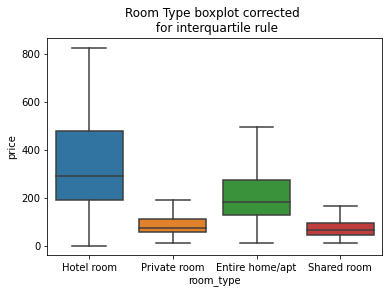

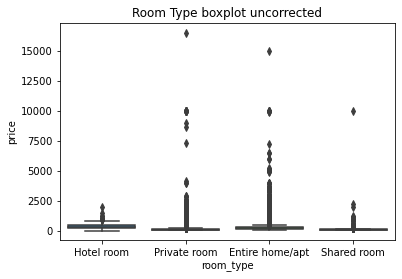

In [47]:
#Display the table of price statistics and counts by New York City burrough.
display(df.groupby('room_type').aggregate({'room_type':'count','price':['mean', 'median','std','min','max']}))

#Plot boxplot with outliers turned off.
sb.boxplot(y = df['price'], x = df['room_type'], showfliers = False)
plt.title('Room Type boxplot corrected \n for interquartile rule')
plt.show()
sb.boxplot(y = df['price'], x = df['room_type'], showfliers = True,saturation=0.75)
plt.title('Room Type boxplot uncorrected')
plt.show()

### AirBNB Listings Statistics by Borough and Room Type in NYC
The listings dataset was aggregated by borough and room type for statistical analysis. The results underscore the need to remove outliers and illogical values from the data.

In [48]:
#Show price statistics by neighborhood group and room type
df_borrough = df[[ 'neighbourhood_group', 'room_type','price']]
display(df_borrough.groupby(['neighbourhood_group', 'room_type']).aggregate({'count',
    'mean', 'median','std', 'min', 'max'}))

price                                     \
                                    median        mean    max         std min   
neighbourhood_group room_type                                                   
Bronx               Entire home/apt  130.0  164.569293   2000  156.115405  28   
                    Hotel room         0.0    0.000000      0         NaN   0   
                    Private room      65.0   90.527112   9994  356.925302  11   
                    Shared room       35.0   70.447368    775  124.059423  10   
Brooklyn            Entire home/apt  169.0  216.452539   7184  228.702022  30   
                    Hotel room       145.0  177.555556    529  194.204860   0   
                    Private room      69.0   86.907680  10000  157.575675  10   
                    Shared room       45.0   70.389535   1000   84.576582  15   
Manhattan           Entire home/apt  205.0  300.645829  15000  420.865138  29   
                    Hotel room       307.0  392.163934   1998  308.268374   0   
                    Private room     100.0  194.915346  16500  549.384274  10   
                    Shared room       82.0  175.124000  10000  662.012440  29   
Queens              Entire home/apt  150.0  191.693713  10000  245.295887  10   
                    Hotel room       209.0  189.888889    282   89.324471   0   
                    Private room      65.0   83.118776   9000  169.268863  19   
                    Shared room       50.0   82.093750   1250  156.164089  16   
Staten Island       Entire home/apt  129.0  180.487179   2500  236.437035  39   
                    Private room      68.0   84.412791    500   65.521555  33   
                    Shared room       59.0   59.000000     59         NaN  59   

                                            
                                     count  
neighbourhood_group room_type               
Bronx               Entire home/apt    736  
                    Hotel room           1  
                    Private room       793  
                    Shared room         38  
Brooklyn            Entire home/apt   8154  
                    Hotel room           9  
                    Private room      6510  
                    Shared room        172  
Manhattan           Entire home/apt  10862  
                    Hotel room         183  
                    Private room      5552  
                    Shared room        250  
Queens              Entire home/apt   2736  
                    Hotel room           9  
                    Private room      3334  
                    Shared room         96  
Staten Island       Entire home/apt    273  
                    Private room       172  
                    Shared room          1

### Correlation Matrix
A correlation matrix was conducted for the listings data. At this point, most of the factors appear to be weakly correlated with price, which is the primary variable of concern.

In [49]:
df.corr(method='pearson')

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
id,1.000000,0.335359,-0.004366,0.079277,0.047596,-0.119177,-0.185724,0.246370,0.040260,0.286508,-0.080899
host_id,0.335359,1.000000,0.027405,0.144694,0.039558,-0.147641,-0.095511,0.271079,-0.024191,0.247358,0.126596
latitude,-0.004366,0.027405,1.000000,0.048995,0.027974,0.030504,-0.033748,-0.037751,0.033737,-0.018182,-0.034825
longitude,0.079277,0.144694,0.048995,1.000000,-0.123122,-0.083799,0.041505,0.102208,-0.071354,0.123042,0.057616
price,0.047596,0.039558,0.027974,-0.123122,1.000000,-0.035304,-0.032691,0.019562,0.042761,0.095482,-0.002458
minimum_nights,-0.119177,-0.147641,0.030504,-0.083799,-0.035304,1.000000,-0.138135,-0.227912,0.117108,-0.061480,-0.201601
number_of_reviews,-0.185724,-0.095511,-0.033748,0.041505,-0.032691,-0.138135,1.000000,0.520748,-0.092435,0.085598,0.640901
reviews_per_month,0.246370,0.271079,-0.037751,0.102208,0.019562,-0.227912,0.520748,1.000000,-0.029656,0.209944,0.815119
calculated_host_listings_count,0.040260,-0.024191,0.033737,-0.071354,0.042761,0.117108,-0.092435,-0.029656,1.000000,0.125885,-0.051553
availability_365,0.286508,0.247358,-0.018182,0.123042,0.095482,-0.061480,0.085598,0.209944,0.125885,1.000000,0.144143


## Map Visualization of the Distribution of Price by Neighborhood in NYC

This section provides analysis on the distribution of price by neighborhood. The mean price by neighborhood was computed from the data, keyed on a geojson file and incorporated into a folium map. There are several clusters of relatively higher prices, but the most significant one is around the Manhattan area.

## Conclusion and TakeAways

- Average listing prices for Manhattan tend to be the highest, followed by Brooklyn, Queens, Staten Island, and the Bronx. Most of the listings are in Manhattan, Brooklyn, and Queens.

- Entire residences/apartments and private rooms comprise ~97% of the listings here. Hotels and shared rooms are less than 2% of the dataset. Hotels tend to have the highest average price followed by residences, private rooms, and lastly shared rooms. Any predictive model underlying algorithms should be differentiated by room type. In terms of business analytics utility, residences and private rooms seem to be the most promising, while hotels and shared rooms may be less useful due to the relatively limited amount of data.
- The variability in the data is significant. The data should be disaggregated by room type, and all values greater than the 3rd quartile + (1.5 * IQR) should be removed. also, all zero values should also be removed.
- It is hypothesized that properties closer to either Manhattan or other significant attractions will have higher list prices ceteris paribus.

# Regression analysis
- What price should be charged based on rental location/ characteristics?

### Clean dataset

In [95]:
hood_price_obj.mean()

,price
neighbourhood,
Allerton,118.777778
Arden Heights,113.857143
Arrochar,132.058824
Arverne,230.263636
Astoria,109.008746
...,...
Windsor Terrace,175.403509
Woodhaven,94.529412
Woodlawn,141.000000


In [101]:
neighborhood = df['neighbourhood'].unique()
neighborhood.sort()
modes=[st.mode(hood_price_obj.get_group(arr)).mode[0][-1] for arr in neighborhood]
counts=[st.mode(hood_price_obj.get_group(arr)).count[0][0] for arr in neighborhood]

neighborhood = df['neighbourhood'].unique()
neighborhood.sort()

df_aux = hood_price_obj.mean()
df_aux['mean']  = df_aux['price'].round(2)
df_aux['median'] = hood_price_obj.median().round(2)
df_aux['mode'] = pd.DataFrame(np.array(modes), index=df_aux.index)
df_aux['count'] = pd.DataFrame(np.array(counts), index=df_aux.index)
df_aux

,price,mean,median,mode,count
neighbourhood,,,,,
Allerton,118.777778,118.78,108.0,85,45
Arden Heights,113.857143,113.86,107.0,40,7
Arrochar,132.058824,132.06,102.0,75,17
Arverne,230.263636,230.26,167.0,100,110
Astoria,109.008746,109.01,82.0,60,686
...,...,...,...,...,...
Windsor Terrace,175.403509,175.40,150.0,150,114
Woodhaven,94.529412,94.53,75.0,55,85
Woodlawn,141.000000,141.00,106.0,43,7


In [103]:
dat = df.loc[:,'neighbourhood_group':'number_of_reviews_ltm']
dat[['mean_price']] = None
dat[['mode_price']] = None
dat[['median_price']] = None
dat[['count_hood']] = None

for n in df_aux.index:
    updated = dat['neighbourhood']==n
    dat.loc[updated, 'mean_price'] = df_aux.loc[n,'mean']
    
    updated = dat['neighbourhood']==n
    dat.loc[updated, 'mode_price'] = df_aux.loc[n,'mode']
    
    updated = dat['neighbourhood']==n
    dat.loc[updated, 'median_price'] = df_aux.loc[n,'median']
    
    updated = dat['neighbourhood']==n
    dat.loc[updated, 'count_hood'] = df_aux.loc[n,'count']
    
dat

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,mean_price,mode_price,median_price,count_hood
0,Brooklyn,Greenpoint,40.737770,-73.953660,Hotel room,308,2,42,2022-07-18,0.30,30,217,4,198.15,150,150.5,708
1,Brooklyn,Kensington,40.645290,-73.972380,Private room,299,30,9,2018-10-19,0.11,9,356,0,151.76,35,85.0,117
2,Queens,Ridgewood,40.703090,-73.899630,Entire home/apt,425,30,13,2019-11-12,0.10,6,365,0,106.47,50,78.0,315
3,Bronx,Mott Haven,40.806350,-73.922010,Private room,60,30,0,NaN,NaN,1,83,0,136.97,65,99.5,92
4,Manhattan,Morningside Heights,40.806300,-73.959850,Private room,75,31,135,2022-07-11,0.95,1,219,4,134.1,80,100.0,188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39876,Manhattan,Ellis Island,40.718220,-74.037940,Entire home/apt,135,365,2,2019-09-16,0.04,7,365,0,198.28,260,178.0,79
39877,Queens,Rosedale,40.647244,-73.720088,Entire home/apt,180,1,5,2022-08-24,1.92,1,0,5,127.24,90,100.0,147
39878,Manhattan,Upper West Side,40.787320,-74.004470,Entire home/apt,240,5,18,2022-08-22,2.87,1,152,18,231.74,150,157.0,1630
39879,Brooklyn,Williamsburg,40.709192,-73.970121,Entire home/apt,400,30,0,NaN,NaN,1,311,0,183.21,200,136.0,2456


#### *analyze neighborhoods that have more than 30 observations*
https://machinelearningmastery.com/a-gentle-introduction-to-the-bootstrap-method/

In [104]:
dat_strap = dat[dat['count_hood']>30]
dat_strap

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,mean_price,mode_price,median_price,count_hood
0,Brooklyn,Greenpoint,40.737770,-73.953660,Hotel room,308,2,42,2022-07-18,0.30,30,217,4,198.15,150,150.5,708
1,Brooklyn,Kensington,40.645290,-73.972380,Private room,299,30,9,2018-10-19,0.11,9,356,0,151.76,35,85.0,117
2,Queens,Ridgewood,40.703090,-73.899630,Entire home/apt,425,30,13,2019-11-12,0.10,6,365,0,106.47,50,78.0,315
3,Bronx,Mott Haven,40.806350,-73.922010,Private room,60,30,0,NaN,NaN,1,83,0,136.97,65,99.5,92
4,Manhattan,Morningside Heights,40.806300,-73.959850,Private room,75,31,135,2022-07-11,0.95,1,219,4,134.1,80,100.0,188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39876,Manhattan,Ellis Island,40.718220,-74.037940,Entire home/apt,135,365,2,2019-09-16,0.04,7,365,0,198.28,260,178.0,79
39877,Queens,Rosedale,40.647244,-73.720088,Entire home/apt,180,1,5,2022-08-24,1.92,1,0,5,127.24,90,100.0,147
39878,Manhattan,Upper West Side,40.787320,-74.004470,Entire home/apt,240,5,18,2022-08-22,2.87,1,152,18,231.74,150,157.0,1630
39879,Brooklyn,Williamsburg,40.709192,-73.970121,Entire home/apt,400,30,0,NaN,NaN,1,311,0,183.21,200,136.0,2456


## Logistic Regression

In [120]:
update = dat_strap['price'] >= dat_strap['mode_price'] 
target = pd.get_dummies(update).iloc[:,0]

### Fit model with Data

In [107]:
#Numerical type, same column size unless int

X = pd.DataFrame({'Const':1,
#     'neighbourhood_group':pd.get_dummies(dat_strap['neighbourhood_group']),#.iloc[:,0],
#     'neighbourhood':pd.get_dummies(dat_strap['neighbourhood']),#.iloc[:,0],
#     'room_type':pd.get_dummies(dat_strap['room_type']),#.iloc[:,0],
    'price':dat_strap['price'],#.iloc[:,0],
    'minimum_nights':dat_strap['minimum_nights'],#.iloc[:,0],
    'number_of_reviews':dat_strap['number_of_reviews'],#.iloc[:,0],
    'availability_365':dat_strap['availability_365'],#.iloc[:,0],
    'number_of_reviews_ltm':dat_strap['number_of_reviews_ltm']})

In [108]:
# Describe the logistic model
mod = sm.Logit(target,X)

# Fit model
fit = mod.fit()

# Summarize model
fit.summary()

/opt/anaconda3/envs/MyEnv/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/envs/MyEnv/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: inf
         Iterations 9


/opt/anaconda3/envs/MyEnv/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/envs/MyEnv/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                38545
Model:                          Logit   Df Residuals:                    38539
Method:                           MLE   Df Model:                            5
Date:                Wed, 30 Nov 2022   Pseudo R-squ.:                     inf
Time:                        08:12:24   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Const                     2.3755      0.036     65.699      0.000       2.305       2.446
price                    -0.0202      0.000    -81.518      0.000      -0.021      -0.020
minimum_nights            0.0063      0.001     11.306      0.000       0.005       0.007
number_of_reviews         0.0018      0.000      6.325      0.000       0.001       0.002
availability_365         -0.0017   9.82e-05    -17.491      0.000      -0.002      -0.002
number_of_reviews_ltm    -0.0103      0.001     -8.629      0.000      -0.013      -0.008
=========================================================================================
"""

In [109]:
fit.params

Const                    2.375457
price                   -0.020214
minimum_nights           0.006300
number_of_reviews        0.001830
availability_365        -0.001718
number_of_reviews_ltm   -0.010269
dtype: float64

It is not straight forward to interpret coefficients of the logistic regression. Here, we show average marginal effects.

In [110]:
# Calculate average marginal effects
mfx = fit.get_margeff()
print(mfx.summary())

        Logit Marginal Effects       
Dep. Variable:                      y
Method:                          dydx
At:                           overall
                           dy/dx    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
price                    -0.0031   2.19e-05   -140.080      0.000      -0.003      -0.003
minimum_nights            0.0010   8.41e-05     11.377      0.000       0.001       0.001
number_of_reviews         0.0003   4.38e-05      6.338      0.000       0.000       0.000
availability_365         -0.0003   1.47e-05    -17.786      0.000      -0.000      -0.000
number_of_reviews_ltm    -0.0016      0.000     -8.665      0.000      -0.002      -0.001


Marginal effects for numerical types are low! Try classification analyses.

In [111]:
def plot_decision_boundary(model,X,y):
    padding=0.15
    res=0.1
    
    #max and min values of x and y of the dataset
    x_min,x_max=X[:,0].min(), X[:,0].max()
    y_min,y_max=X[:,1].min(), X[:,1].max()
    
    #range of x's and y's
    x_range=x_max-x_min
    y_range=y_max-y_min
    
    #add padding to the ranges
    x_min -= x_range * padding
    y_min -= y_range * padding
    x_max += x_range * padding
    y_max += y_range * padding

    #create a meshgrid of points with the above ranges
    xx,yy=np.meshgrid(np.arange(x_min,x_max,res),np.arange(y_min,y_max,res))
    
    #use model to predict class at each point on the grid
    #ravel turns the 2d arrays into vectors
    #c_ concatenates the vectors to create one long vector on which to perform prediction
    #finally the vector of prediction is reshaped to the original data shape.
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])   
    Z = Z.reshape(xx.shape)
    
    #plot the contours on the grid
    plt.figure(figsize=(8,6))
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    
    #plot the original data and labels
    plt.scatter(X[:,0], X[:,1], s=35, c=y, cmap=plt.cm.Spectral)

In [119]:
target

0        0
1        0
2        0
3        1
4        1
        ..
39876    1
39877    0
39878    0
39879    0
39880    1
Length: 38545, dtype: uint8

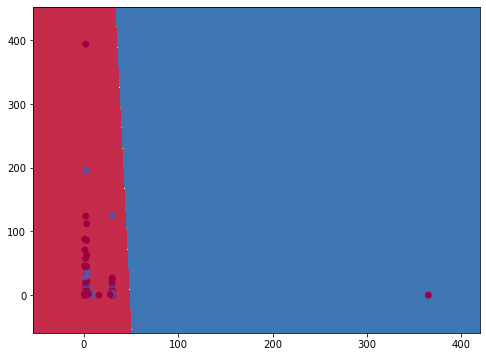

In [124]:
model = LogisticRegression(solver='newton-cg')
model.fit(X[['minimum_nights','number_of_reviews']].values, target.values)

samp = X.sample(100)
plot_decision_boundary(model,
    samp[['minimum_nights','number_of_reviews']].values,
                       pd.DataFrame(target).loc[samp.index,:].values)

# Implementing Naive Bayes

# Technology Stack

In [125]:
!which python

/opt/anaconda3/envs/MyEnv/bin/python


In [126]:
!which jupyter

/opt/anaconda3/envs/MyEnv/bin/jupyter


In [127]:
!which python3

/opt/anaconda3/envs/MyEnv/bin/python3


# Github Repository, Handles, and Evaluation

https://github.com/Naren1610/IST5520GrpProj/tree/milestone2

### IST5520GrpProj

<h4 align="left"> Ronald Adomako, adomakor412 </h3>
<h4 align="left"> Idris Dobbs, idobbs-2012 </h3>
<h4 align="left"> Narendra Chigili, Naren1610 </h3>
<h4 align="left"> Nikhil Srirama Sai, SaiNikhilPalaparthi </h3>